In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
import xarray as xr
import matplotlib.pyplot as plt
from scipy import signal
from scipy import interpolate
import ghibtools as gh
import pandas as pd
import seaborn as sns
import neurokit2 as nk
from params import *
from bibliotheque import *
import physio
import time

from preproc import preproc_job
from compute_resp_features import label_respiration_features_job

In [66]:
def detect_cross(sig, threshold, show = False):
    """
    Detect zero-crossings ("zerox")
    ------
    inputs =
    - sig : numpy 1D array
    - show : plot figure showing rising zerox in red and decaying zerox in green (default = False)
    output =
    - pandas dataframe with index of rises and decays
    """
    rises, = np.where((sig[:-1] <=threshold) & (sig[1:] >threshold)) # detect where sign inversion from - to +
    decays, = np.where((sig[:-1] >=threshold) & (sig[1:] <threshold)) # detect where sign inversion from + to -
    if rises[0] > decays[0]: # first point detected has to be a rise
        decays = decays[1:] # so remove the first decay if is before first rise
    if rises[-1] > decays[-1]: # last point detected has to be a decay
        rises = rises[:-1] # so remove the last rise if is after last decay

    if show:
        fig, ax = plt.subplots(figsize = (15,5))
        ax.plot(sig)
        ax.plot(rises, sig[rises], 'o', color = 'r', label = 'rise')
        ax.plot(decays, sig[decays], 'o', color = 'g', label = 'decay')
        ax.set_title('Zero-crossing')
        ax.legend()
        plt.show()

    return pd.DataFrame.from_dict({'rises':rises, 'decays':decays}, orient = 'index').T

In [224]:
run_key = 'P18_ses03'
ds = preproc_job.get(run_key)['eeg_clean']

In [225]:
srate = ds.attrs['srate']

In [226]:
sig = ds.sel(chan = 'Oz').values

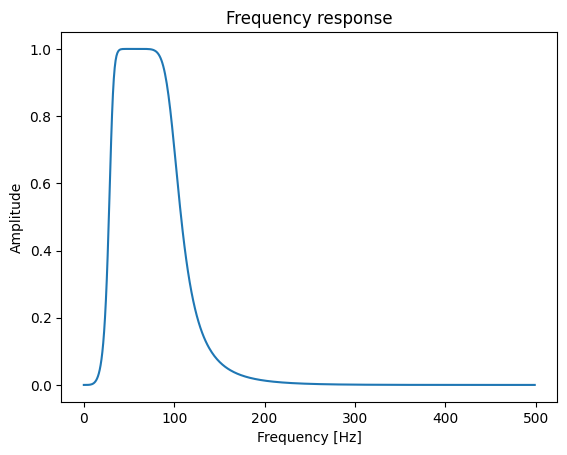

In [227]:
lf = 30
hf = 100
sig_filtered = gh.iirfilt(sig, srate, lf, hf, ftype = 'butter', show = True)

In [228]:
sig_amp = gh.get_amp(sig_filtered)

In [229]:
def compute_rms(x):
    """Fast root mean square."""
    n = x.size
    ms = 0
    for i in range(n):
        ms += x[i] ** 2
    ms /= n
    return np.sqrt(ms)

In [230]:
def sliding_rms(x, sf, window=0.5, step=0.2, interp=True):
    halfdur = window / 2
    n = x.size
    total_dur = n / sf
    last = n - 1
    idx = np.arange(0, total_dur, step)
    out = np.zeros(idx.size)

    # Define beginning, end and time (centered) vector
    beg = ((idx - halfdur) * sf).astype(int)
    end = ((idx + halfdur) * sf).astype(int)
    beg[beg < 0] = 0
    end[end > last] = last
    # Alternatively, to cut off incomplete windows (comment the 2 lines above)
    # mask = ~((beg < 0) | (end > last))
    # beg, end = beg[mask], end[mask]
    t = np.column_stack((beg, end)).mean(1) / sf



    # Now loop over successive epochs
    for i in range(idx.size):
        out[i] = compute_rms(x[beg[i] : end[i]])

    # Finally interpolate
    if interp and step != 1 / sf:
        f = interpolate.interp1d(t, out, kind="cubic", bounds_error=False, fill_value=0, assume_sorted=True)
        t = np.arange(n) / sf
        out = f(t)

    return t, out

In [231]:
t, rms = sliding_rms(sig_filtered, sf=srate)

In [232]:
n_std = 3
sig_cross = rms
crossings = detect_cross(sig_cross, np.mean(sig_cross) + n_std * np.std(sig_cross))

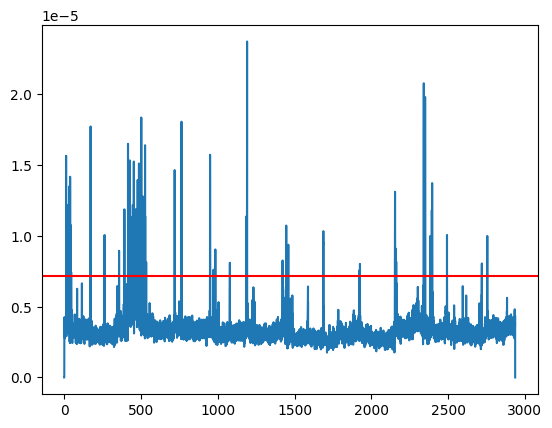

In [233]:
fig, ax = plt.subplots()
ax.plot(t, rms)
# ax.axhline(np.median(rms) + 15 * gh.mad(rms), color = 'r')
ax.axhline(np.mean(rms) + n_std * np.std(rms), color = 'r')

In [234]:
def compute_artifact_features(crossings, rms, srate):
    features = pd.DataFrame()
    features['start_ind'] = crossings['rises'].astype(int)
    features['stop_ind'] = crossings['decays'].astype(int)
    features['start_t'] = features['start_ind'] / srate
    features['stop_t'] = features['stop_ind'] / srate
    features['duration'] = features['stop_t'] - features['start_t']
    features['size'] = np.ones(features.shape[0]) * np.nan
    for i, row in features.iterrows():
        features.loc[i, 'size'] = np.trapz(y=rms[int(row['start_ind']):int(row['stop_ind'])])
    return features

In [235]:
feats = compute_artifact_features(crossings, rms, srate)

In [236]:
feats

,start_ind,stop_ind,start_t,stop_t,duration,size
0,11637,13410,11.637,13.410,1.773,0.018945
1,14318,14957,14.318,14.957,0.639,0.006343
2,15747,16061,15.747,16.061,0.314,0.002557
3,16599,16701,16.599,16.701,0.102,0.000727
4,17081,17529,17.081,17.529,0.448,0.004208
...,...,...,...,...,...,...
84,2394054,2394659,2394.054,2394.659,0.605,0.006129
85,2395803,2397864,2395.803,2397.864,2.061,0.020611
86,2493085,2493647,2493.085,2493.647,0.562,0.005071
87,2720142,2720487,2720.142,2720.487,0.345,0.002659


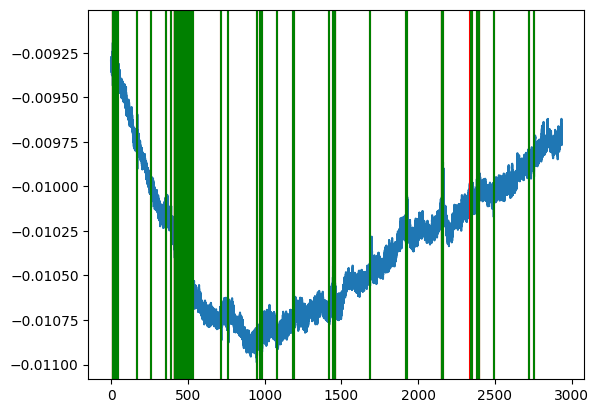

In [237]:
fig, ax = plt.subplots()
ax.plot(t, sig)
for i in feats['start_t']:
    ax.axvline(i, color = 'r')
for j in feats['stop_t']:
    ax.axvline(j, color = 'g')
# ax.set_xlim(542, 544)

In [238]:
resp_features = label_respiration_features_job.get(run_key).to_dataframe()

In [239]:
resp_features_artifact = resp_features.copy()
resp_features_artifact['artifact'] = np.ones(resp_features_artifact.shape[0]) * np.nan
for i , row in resp_features.iterrows():
    mask = feats[(feats['start_t'] > row['inspi_time']) & (feats['start_t'] < row['next_inspi_time'])]
    if mask.shape[0] != 0:
        resp_features_artifact.loc[i,'artifact'] = 1
    else:
        resp_features_artifact.loc[i,'artifact'] = 0

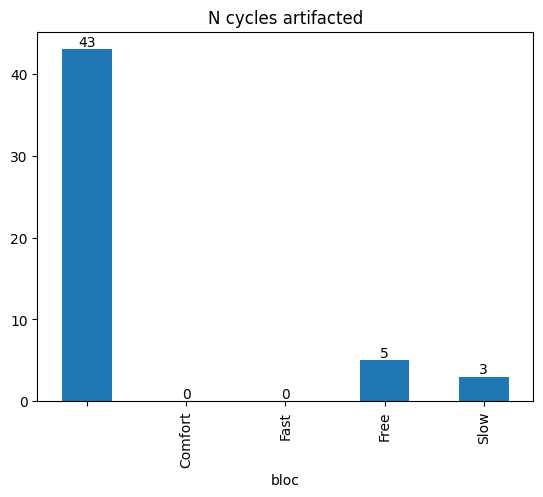

In [240]:
fig, ax = plt.subplots()
resp_features_artifact.groupby('bloc')['artifact'].sum().plot.bar(ax=ax)
ax.set_title('N cycles artifacted')
for bar in ax.containers:
    ax.bar_label(bar)